# 1. IMPORT LIBRARIES

In [17]:
# MACHINE LEARNING
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import (r2_score, roc_auc_score,
                             classification_report, confusion_matrix,
                             roc_curve, accuracy_score, mean_squared_error)
import pickle

# SOUND MANIPULATION
import soundfile as sf
from soundfile import SoundFile

# AUDIO ANALISIS
import librosa
import librosa.display
from scipy.fft import fft, rfftfreq, rfft, fftfreq
from scipy.stats import kurtosis
import antropy as ant

# FILTERS
from pedalboard import LadderFilter, Pedalboard

# DATA MANIPULATION
import numpy as np
import pandas as pd
import math

# DATA PLOT
import matplotlib.pyplot as plt
import seaborn as sbn

# 2. LOAD SOUNDS

### NUMERO DE SAMPLES POR INSTRUMENTO

In [2]:
numSounds = 50

### INSTRUMENTOS 

In [3]:
instruments = ["Kick", "Snare", "Hihat", "Guitar", "Bass", "Vox"]

### GENERAL DATA

In [4]:
generalPath = "../InstrumentsClassifier/Instruments/"

instrumentsAudio = []
for instrument in instruments:
    instrumentPath = generalPath + instrument + "/"
    sound = []
    
    for i in range(numSounds):
        path = instrumentPath + instrument + "_" + str(i+1) + ".wav"
        audio = SoundFile(path)

        if audio.channels == 1:
            samples, sr = sf.read(path)
            sound.append([samples, sr])
        else:
            samples, sr = sf.read(path)
            sound.append([samples[:,0], sr])
            
    instrumentsAudio.append([instrument, sound])
    
# 0 = INSTRUMENTO (0 - n Instrumentos)
# 1 = NOMBRE DE INSTRUMENTO O ARREGLO (0 o 1)
# 2 = SELECCIONAR QUE SAMPLE SE QUIERE (0 - n Samples)
# 3 = SELECCIONAR SAMPLES O SAMPLE RATE (0 o 1)

# 3. SEE SOME SOUNDS

### AUDIO IN TIME DOMAIN

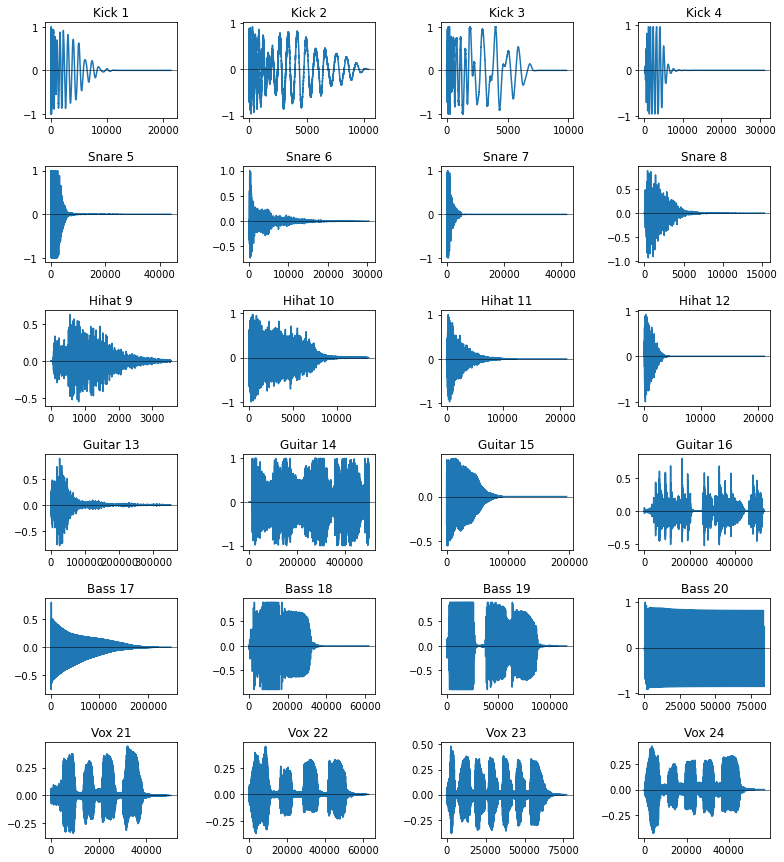

In [5]:
inTime = plt.figure("Time Domain", figsize=(13,15))
inTime.subplots_adjust(hspace=0.5, wspace=0.5)

instrument = 0
for i in range(1, (len(instruments)*4) + 1):
    ax = inTime.add_subplot(len(instruments), 4, i)
    ax.plot(instrumentsAudio[instrument][1][i][0])
    ax.set_title(instruments[instrument] + " " + str(i))
    ax.axhline(0, color='black', linewidth=0.5)
    
    if i % 4 == 0:
        instrument += 1

plt.show()

### AUDIO IN FREQUENCY DOMAIN

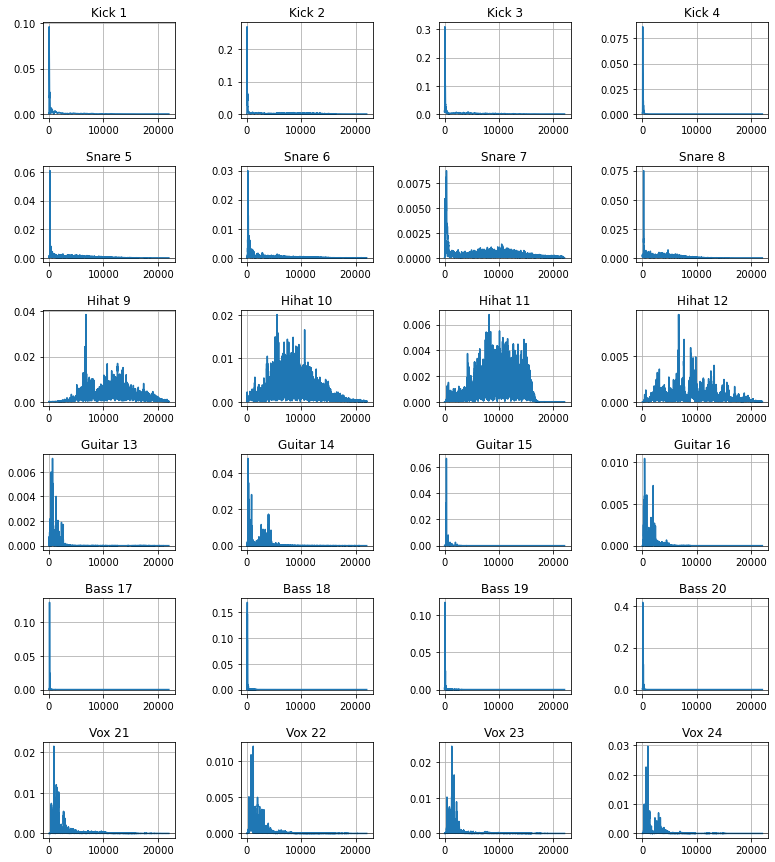

In [6]:
inFrequency = plt.figure("Frequency Domain", figsize=(13,15))
inFrequency.subplots_adjust(hspace=0.5, wspace=0.5)

instrument = 0
for i in range(1, (len(instruments)*4) + 1):
    samples = instrumentsAudio[instrument][1][i][0]
    sr = instrumentsAudio[instrument][1][i][1]
    
    N = len(samples)
    T = 1/sr
    yf = fft(samples)
    xf = fftfreq(N, T)[:N//2]
    
    ax = inFrequency.add_subplot(len(instruments), 4, i)
    ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax.set_title(instruments[instrument] + " " + str(i))
    ax.grid()
    ax.axhline(0, color='black', linewidth=0.5)
    
    if i % 4 == 0:
        instrument += 1
        
plt.show()

# 4. OBTAIN DATA

### FUNCTIONS TO USE IN ORDER TO OBTAIN AUDIO DESCRIPTORS

In [5]:
def getVectorTime(inSamples, inSampleRate):
    return np.arange(0, len(inSamples), 1) / inSampleRate

def getSpectrum(inSamples):
    return(np.abs(rfft(inSamples)))

def getFrequency(inSamples, inSampleRate):
    return(rfftfreq(len(inSamples), 1 / inSampleRate))

def getCentroid(inX, inY):
    return np.sum(inY * inX) / np.sum(inY)

def getPeak(inX, inY):
    peakIndex = np.argmax(np.array(inY))
    return inX[peakIndex]

def getSpread(inX, inY):
    centroid = getCentroid(inX, inY)
    return math.sqrt(np.abs(np.sum((inX - centroid) ** 2 * inY) / np.sum(inY)))

def getMFCC(inSamples, inSampleRate):
    mfccValue = librosa.feature.mfcc(inSamples, sr=inSampleRate, n_mfcc=13)
    return mfccValue

def getZeroCrossing(inData):
    return librosa.feature.zero_crossing_rate(inData).mean()

def getKurtosis(inX, inY):
    centroid = getCentroid(inX, inY)
    spread = getSpread(inX, inY)
    return np.sum((inX - centroid) ** 4 * inY) / (spread ** 4 * np.sum(inY)) - 3

def getEntropy(amplitude):
    normalizedAmplitude = amplitude / sum(amplitude)
    entropy = -np.sum(normalizedAmplitude * np.log(normalizedAmplitude)) / np.log(len(amplitude))
    return entropy

def getRolloff(inX, inY, treshold = 0.95):
    cumsum = np.cumsum(inY)
    cont = 0
    rolloff = 0
    for accum in cumsum:
        if accum > (cumsum[-1] * treshold):
            rolloff = inX[cont]
            break
        cont += 1
    return rolloff

def getDecrease(inSamples):
    amplitude = np.abs(rfft(inSamples))
    primero = amplitude[0]
    amplitude = np.delete(amplitude,0)
    decrease = np.sum(amplitude - primero) / ((len(amplitude)-1) * np.sum(amplitude))
    return decrease

def getSlope(inSamples, inSampleRate):
    amplitude = np.abs(rfft(inSamples))
    frequency = rfftfreq(len(inSamples), 1 / inSampleRate)
    slope = np.sum((amplitude - amplitude.mean()) * (frequency - frequency.mean())) / np.sum((frequency - frequency.mean()) ** 2)
    return slope

def getFlatness(inSamples):
    return librosa.feature.spectral_flatness(inSamples).mean()

def getFlux(inSamples):
    return librosa.onset.onset_strength(inSamples).mean()

'''def getDecrease(inY):
    oriArreglo = inY
    first = inY[0]
    np.delete(inY, 0)

    num = np.subtract(inY, first)
    den = np.arange(1, len(oriArreglo)+1, 1)

    return np.sum(num / den) / np.sum(inY)'''

'def getDecrease(inY):\n    oriArreglo = inY\n    first = inY[0]\n    np.delete(inY, 0)\n\n    num = np.subtract(inY, first)\n    den = np.arange(1, len(oriArreglo)+1, 1)\n\n    return np.sum(num / den) / np.sum(inY)'

### MAKE DESCRIPTORS

In [6]:
descriptors = ['Instrument', 'ID', 'Centroid_Freq', 'Peak_Freq', 'Spread_Freq', 'Kurtosis_Freq', 'Entropy_Freq', 'RollOff_Freq', 
               'Decrease', 'Slope', 'Flatness', 'Flux', 
               'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13',
               'Centroid_Time', 'Peak_Time', 'Spread_Time', 'ZeroCrossing_Time', 'Kurtosis_Time', 'RollOff_Time', 'Decrease_Time']

In [7]:
sounds_info = []

cont = 0
for instrument in instruments:
    sound = []
    
    for i in range(numSounds):    
        fila = []
        samples = instrumentsAudio[cont][1][i][0]
        sr = instrumentsAudio[cont][1][i][1]
        
        fila.append(instrument)
        fila.append(cont+1)
        
        # IN FREQUENCY DOMAIN
        spectrum = getSpectrum(samples)
        frequency = getFrequency(samples, sr)

        fila.append(getCentroid(frequency, spectrum))
        fila.append(getPeak(frequency, spectrum))
        fila.append(getSpread(frequency, spectrum))
        fila.append(getKurtosis(frequency, spectrum))
        fila.append(getEntropy(spectrum))
        fila.append(getRolloff(frequency, spectrum))
        
        # NOT READY YET
        fila.append(getDecrease(spectrum))
        fila.append(getSlope(samples, sr))
        fila.append(getFlatness(samples))
        fila.append(getFlux(samples))
        for mfcc in getMFCC(samples, sr):
            fila.append(mfcc.mean())

        # IN TIME DOMAIN
        time = getVectorTime(samples, sr)

        fila.append(getCentroid(time, samples))
        fila.append(getPeak(time, samples))
        fila.append(getSpread(time, samples))
        fila.append(getZeroCrossing(samples))
        fila.append(getKurtosis(time, samples))
        fila.append(getRolloff(time, samples))
        fila.append(getDecrease(samples))
        
        sounds_info.append(fila)
        
    cont += 1

datos = pd.DataFrame(sounds_info, columns=descriptors)
datos

,Instrument,ID,Centroid_Freq,Peak_Freq,Spread_Freq,Kurtosis_Freq,Entropy_Freq,RollOff_Freq,Decrease,Slope,...,MFCC_11,MFCC_12,MFCC_13,Centroid_Time,Peak_Time,Spread_Time,ZeroCrossing_Time,Kurtosis_Time,RollOff_Time,Decrease_Time
0,Kick,1,2284.889218,55.799241,4254.374655,6.767613,0.770839,12629.228174,-0.006645,-0.001276,...,4.950433,4.627034,3.634569,0.027516,0.000794,0.069228,0.229167,7.035167,0.000000,-1.104418e-04
1,Kick,1,2362.052887,41.332771,3896.753265,5.434133,0.788516,11376.845213,-0.010411,-0.001547,...,8.374239,7.274329,6.836314,0.008694,0.000091,0.040428,0.145299,37.435758,0.000159,6.781112e-05
2,Kick,1,4167.864858,55.215256,4945.284352,-0.280414,0.827128,13859.029182,-0.008191,-0.001201,...,5.838897,21.613707,10.176115,0.416963,0.007279,0.275133,0.016416,-6.196964,0.000000,1.543427e-04
3,Kick,1,3424.106537,44.798862,4233.750465,1.984616,0.823115,12507.842341,-0.009044,-0.001550,...,9.837214,8.859652,6.960671,0.042620,0.003061,0.036026,0.008008,-3.761306,0.000000,-8.416776e-04
4,Kick,1,114.889174,49.582396,193.671907,3149.876256,0.516479,281.911340,-0.004287,-0.000907,...,6.520444,5.927621,5.252067,0.042454,0.090408,0.042886,0.098137,-0.855035,0.000000,-1.414401e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Vox,6,1268.874044,46.758245,1994.392321,9.921558,0.780137,5706.055884,-0.002254,-0.002771,...,-1.895164,11.809999,10.837447,2.481487,1.476871,0.969432,0.015885,-1.427395,1.476485,-1.225806e-05
296,Vox,6,2498.290443,103.383496,2255.265905,4.777679,0.882215,6488.219452,-0.004085,-0.006803,...,-7.747476,7.910738,-1.519503,2.678509,4.668866,2.063655,0.083522,-1.376572,0.000000,5.280423e-07
297,Vox,6,1796.303036,487.244314,1358.757151,27.064067,0.818315,3581.172548,-0.006189,-0.003455,...,-19.511840,-7.859011,-21.811475,1.872196,1.680703,0.158056,0.085561,94.822258,0.038367,1.381563e-05
298,Vox,6,1476.616931,153.606321,1323.439841,22.056159,0.796826,3852.467930,-0.006097,-0.004005,...,3.059276,-2.733063,-23.160438,0.855041,0.388549,0.157896,0.065254,2.414348,0.033401,1.794867e-05


In [8]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Instrument         300 non-null    object 
 1   ID                 300 non-null    int64  
 2   Centroid_Freq      300 non-null    float64
 3   Peak_Freq          300 non-null    float64
 4   Spread_Freq        300 non-null    float64
 5   Kurtosis_Freq      300 non-null    float64
 6   Entropy_Freq       300 non-null    float64
 7   RollOff_Freq       300 non-null    float64
 8   Decrease           300 non-null    float64
 9   Slope              300 non-null    float64
 10  Flatness           300 non-null    float64
 11  Flux               300 non-null    float64
 12  MFCC_1             300 non-null    float64
 13  MFCC_2             300 non-null    float64
 14  MFCC_3             300 non-null    float64
 15  MFCC_4             300 non-null    float64
 16  MFCC_5             300 non

# 5. ANALIZE THE DATA

## Descripción de variables: 

* ID: Valor númerico de instrumento.
* Centroid: Centro energético de la señal.
* Peak: Frecuencia de mayor amplitud de la señal.
* Spread: Zona con mayor energía de la señal.
* Zero Crossing: Velocidad de cambio de signo de la señal.
* Kurtosis: Peso de datos atípicos en las colas de la señal.
* Entropy: Porcentaje de ruido blanco en la señal.
* Roll Off: Estimación de la frecuencia de corte de la señal.
* Decrease: Caída energética promedio de la señal.
* Slope: Grado de inclinación/pronunciación de la señal.
* Flatness: Razón entre la media geométrica y la media aritmética de la señal.
* Flux: Medida de la rapidez con la que cambia el espectro de potencia de una señal.
* MFCC: Coeficientes relacionados al pitch que representan un sonido (Coeficientes cepstrales de la señal con una ponderación de escala de Mel).

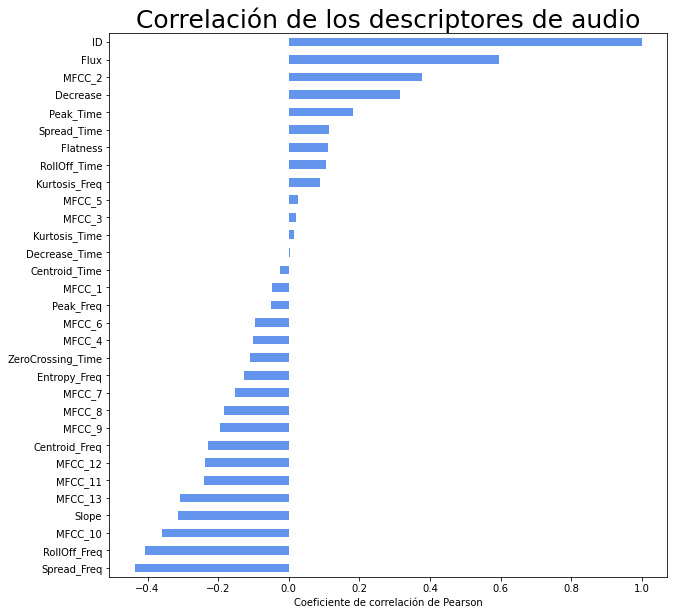

In [11]:
datos.corrwith(datos.ID).sort_values().plot.barh(figsize=(10,10), color='cornflowerblue')
plt.xlabel('Coeficiente de correlación de Pearson')
plt.title('Correlación de los descriptores de audio', fontsize = 25);

In [12]:
top5UpDownData = datos[['ID', 'Flux', 'MFCC_2', 'Decrease', 'Peak_Time', 'Spread_Freq', 'RollOff_Freq', 'MFCC_10', 'Slope', 'MFCC_13']]

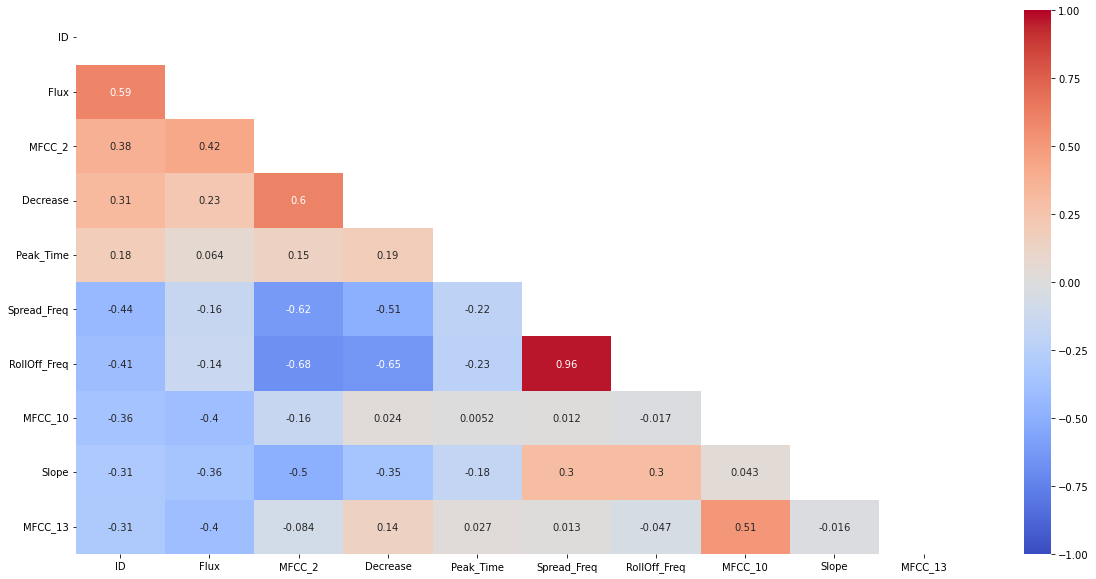

In [13]:
plt.figure(figsize=(20,10))
corr_df = top5UpDownData.corr()
mask = np.triu(np.ones_like(corr_df))
sbn.heatmap(top5UpDownData.corr(),cmap='coolwarm',annot=True, annot_kws={'fontsize':10}, mask=mask, vmin=-1, vmax=1);

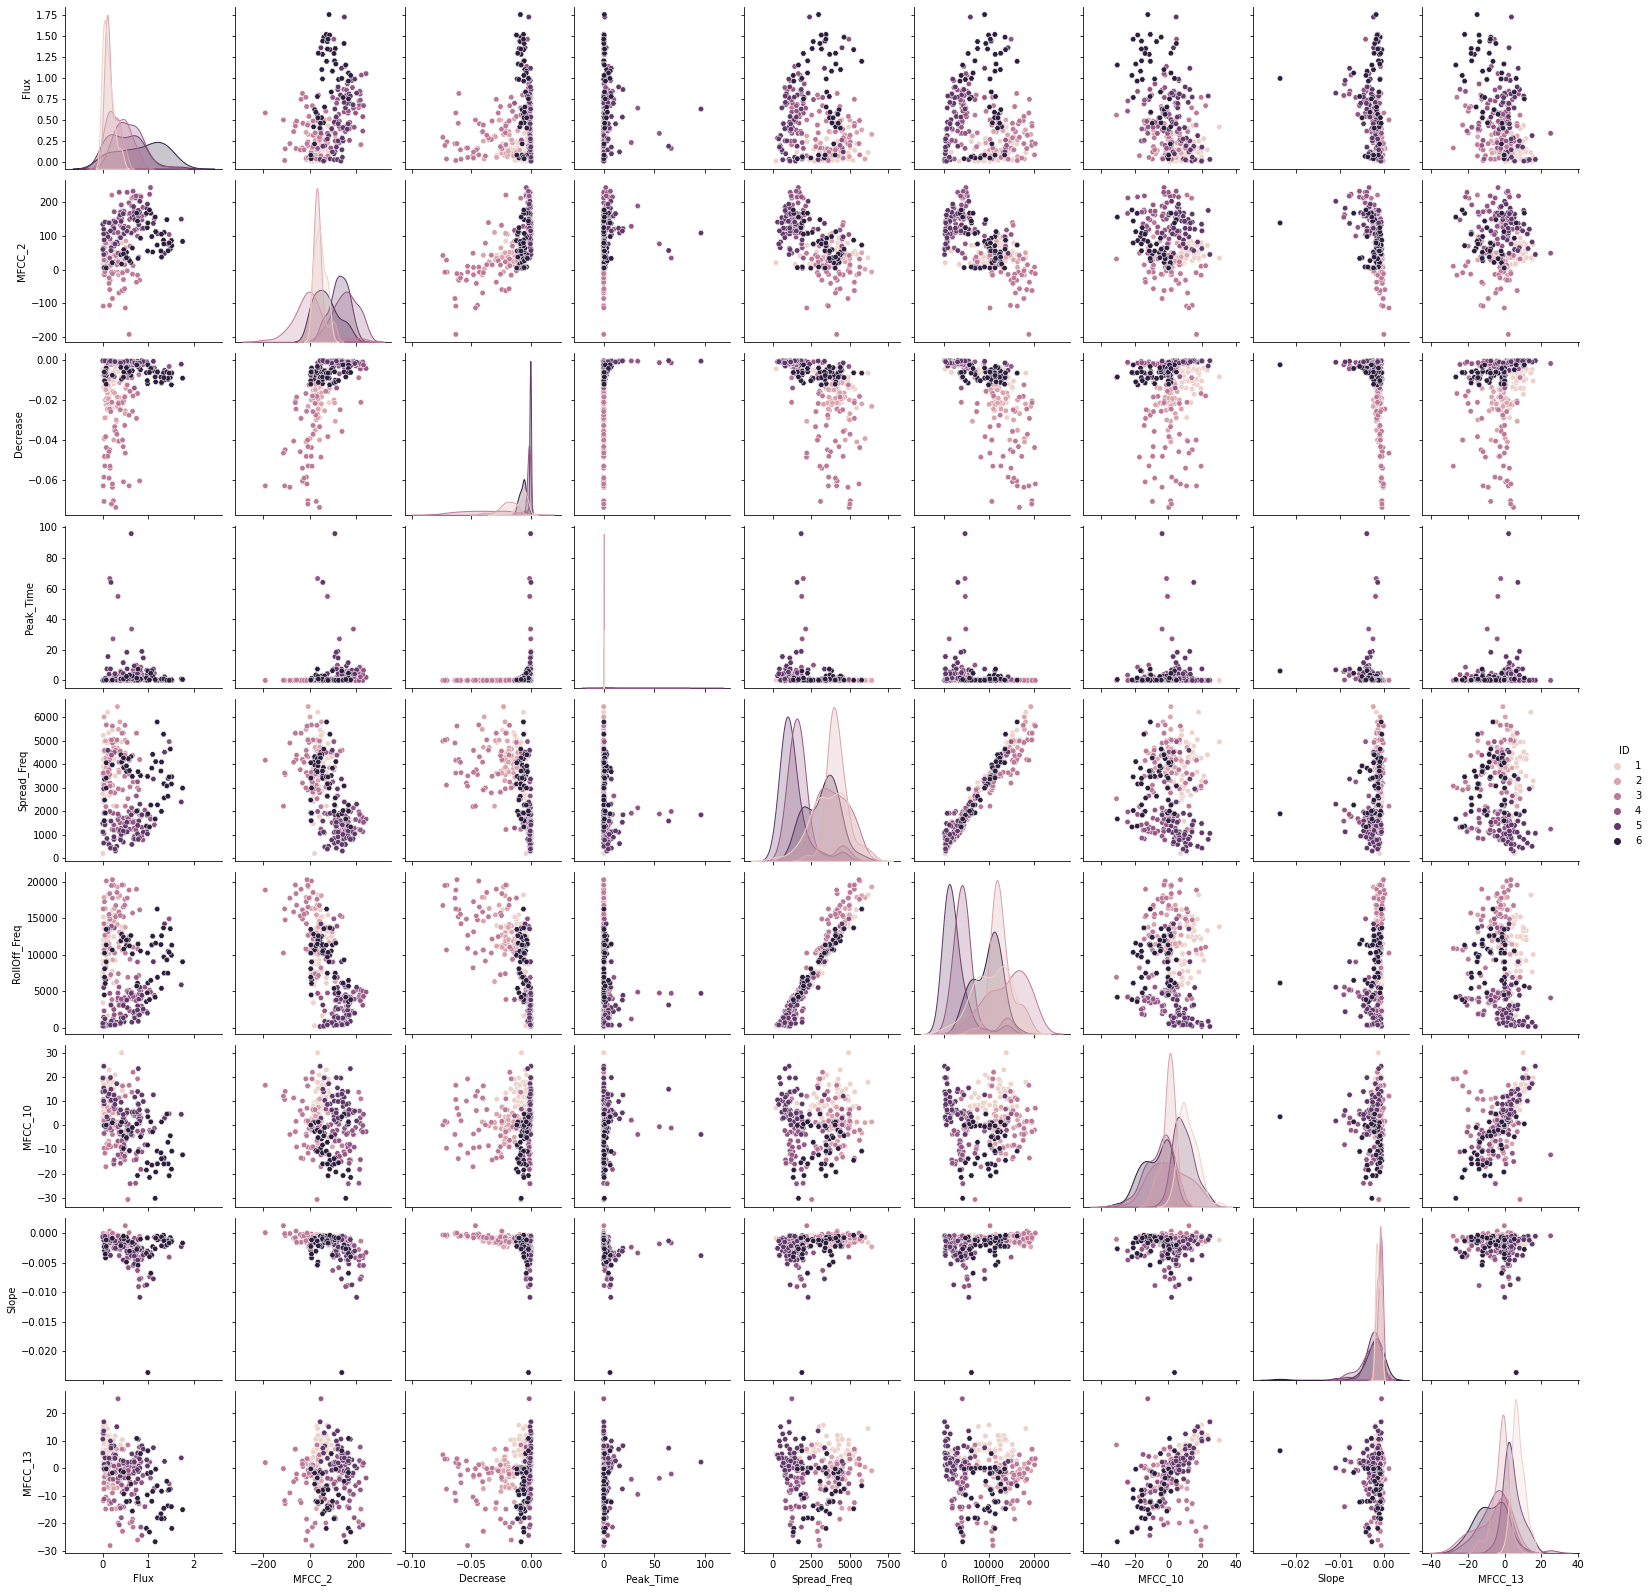

In [14]:
sbn.pairplot(top5UpDownData, hue='ID', markers='H');

# 6. TRAINING

### DEFINE X NAMES FOR TRAINING

In [9]:
x_names = ['Centroid_Freq', 'Spread_Freq', 'Peak_Freq', 'Centroid_Time', 'Slope', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 
           'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', ]

### SPLIT TRAIN AND TEST DATA

In [10]:
x_train, x_test, y_train, y_test = train_test_split(datos[x_names], datos.ID, test_size=0.2, random_state=69)

### DECISION TREE 

In [63]:
model_tree = DecisionTreeClassifier(max_depth=8)
model_tree.fit(x_train, y_train)
y_results_tree = model_tree.predict(x_test)

In [64]:
print(classification_report(y_test, y_results_tree))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        11
           2       0.64      0.82      0.72        11
           3       0.83      0.62      0.71         8
           4       0.86      0.67      0.75         9
           5       0.92      0.92      0.92        13
           6       0.38      0.38      0.38         8

    accuracy                           0.77        60
   macro avg       0.76      0.73      0.74        60
weighted avg       0.78      0.77      0.77        60



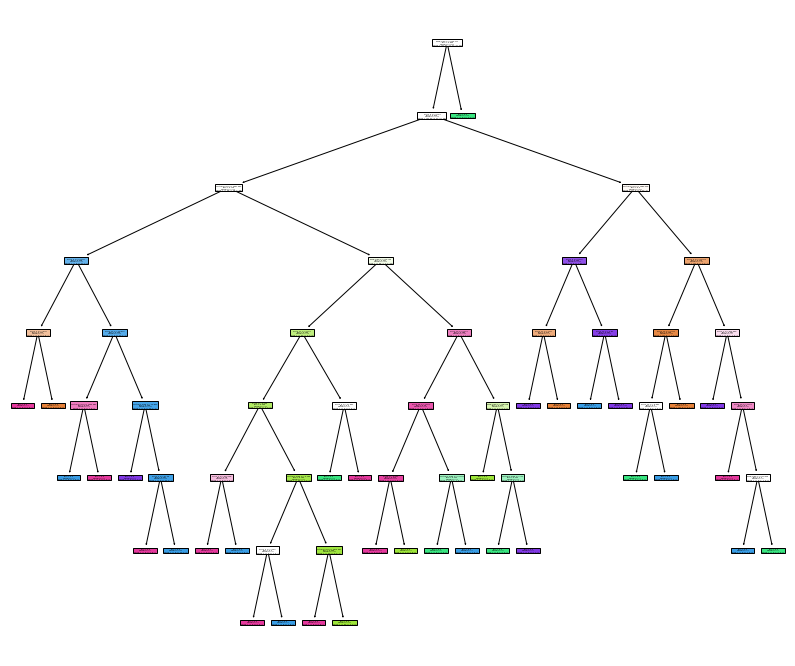

In [65]:
plt.figure(figsize=(14, 12))
plot_tree(model_tree, filled=True, feature_names= x_names)
plt.show()

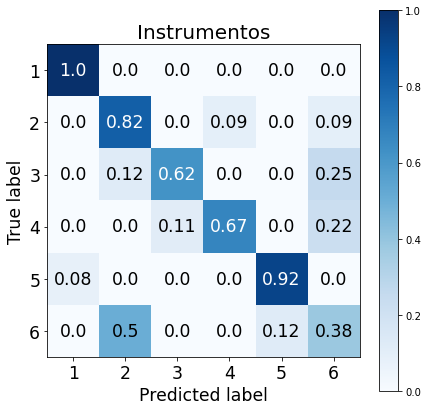

In [66]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_tree, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

In [151]:
#print('Area under the ROC curve:',"% 1.3f" % roc_auc_score(y_test, y_results_tree))

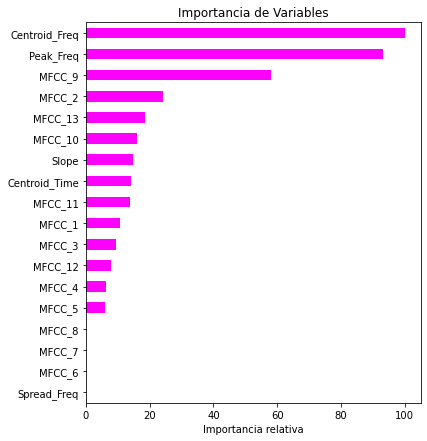

In [67]:
f_imp = pd.DataFrame(model_tree.feature_importances_,
                     index=x_names, columns=['imp'])
#calculo de importancia relativa
f_imp['imp_rel'] = (f_imp/f_imp.max()*100)
f_imp.sort_values('imp_rel',ascending=True).imp_rel.plot.barh(figsize=(6,7),
                                                              title='Importancia de Variables',color='magenta')
plt.xlabel('Importancia relativa');

In [68]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0
guitarAcertados, numGuitar = 0, 0
bassAcertados, numBass = 0, 0
voxAcertados, numVox = 0, 0

for num in range(len(y_results_tree)):
    if x_test.index[num] <= 49:
        if y_results_tree[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_tree[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99 and x_test.index[num] <= 149:
        if y_results_tree[num] == 3:
            hihatAcertados += 1
        numHihat += 1
        
    elif x_test.index[num] > 149 and x_test.index[num] <= 199:
        if y_results_tree[num] == 4:
            guitarAcertados += 1
        numGuitar += 1
        
    elif x_test.index[num] > 199 and x_test.index[num] <= 249:
        if y_results_tree[num] == 5:
            bassAcertados += 1
        numBass += 1
        
    elif x_test.index[num] > 249:
        if y_results_tree[num] == 6:
            voxAcertados += 1
        numVox += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihats", hihatAcertados, "predijo como hihat")
print("De", numGuitar, "Guitars", guitarAcertados, "predijo como guitar")
print("De", numBass, "Basses", bassAcertados, "predijo como Bass")
print("De", numVox, "Voxes", voxAcertados, "predijo como Vox")

De 11 kicks 11 predijo como kick
De 11 Snares 9 predijo como snare
De 8 Hihats 5 predijo como hihat
De 9 Guitars 6 predijo como guitar
De 13 Basses 12 predijo como Bass
De 8 Voxes 3 predijo como Vox


### RANDOM FOREST

In [11]:
clf = RandomForestClassifier(n_estimators= 20, 
                             max_depth = 9, 
                             random_state = 10)
clf.fit(x_train, y_train)
y_results_RandomForest = clf.predict(x_test)

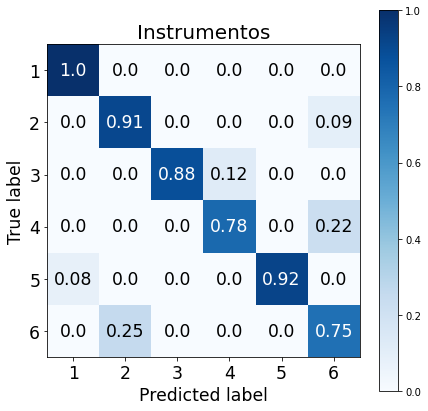

In [12]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_RandomForest, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

In [13]:
print(classification_report(y_test, y_results_RandomForest))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        11
           2       0.83      0.91      0.87        11
           3       1.00      0.88      0.93         8
           4       0.88      0.78      0.82         9
           5       1.00      0.92      0.96        13
           6       0.67      0.75      0.71         8

    accuracy                           0.88        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.89      0.88      0.88        60



Text(0.5, 0, 'Importancia relativa')

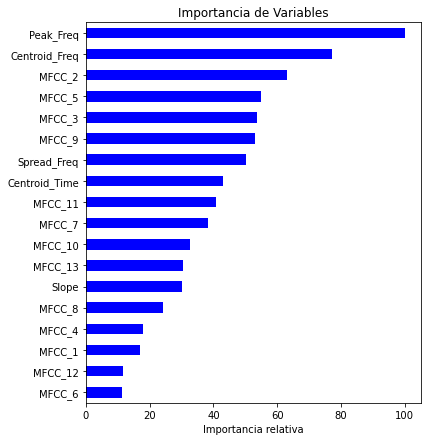

In [14]:
f_imp = pd.DataFrame(clf.feature_importances_,
                     index=x_names, columns=['imp'])
#calculo de importancia relativa
f_imp['imp_rel'] = (f_imp/f_imp.max()*100)
f_imp.sort_values('imp_rel',ascending=True).imp_rel.plot.barh(figsize=(6,7), title='Importancia de Variables', color='blue')
plt.xlabel('Importancia relativa')

In [15]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0
guitarAcertados, numGuitar = 0, 0
bassAcertados, numBass = 0, 0
voxAcertados, numVox = 0, 0
 
for num in range(len(y_results_RandomForest)):
    if x_test.index[num] <= 49:
        if y_results_RandomForest[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_RandomForest[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99 and x_test.index[num] <= 149:
        if y_results_RandomForest[num] == 3:
            hihatAcertados += 1
        numHihat += 1
        
    elif x_test.index[num] > 149 and x_test.index[num] <= 199:
        if y_results_RandomForest[num] == 4:
            guitarAcertados += 1
        numGuitar += 1
        
    elif x_test.index[num] > 199 and x_test.index[num] <= 249:
        if y_results_RandomForest[num] == 5:
            bassAcertados += 1
        numBass += 1
        
    elif x_test.index[num] > 249:
        if y_results_RandomForest[num] == 6:
            voxAcertados += 1
        numVox += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihats", hihatAcertados, "predijo como hihat")
print("De", numGuitar, "Guitars", guitarAcertados, "predijo como guitar")
print("De", numBass, "Basses", bassAcertados, "predijo como Bass")
print("De", numVox, "Voxes", voxAcertados, "predijo como Vox")

De 11 kicks 11 predijo como kick
De 11 Snares 10 predijo como snare
De 8 Hihats 7 predijo como hihat
De 9 Guitars 7 predijo como guitar
De 13 Basses 12 predijo como Bass
De 8 Voxes 6 predijo como Vox


### SAVE MODEL

In [21]:
# save the model to disk
filename = 'Models/randomForest_Model.sav'
pickle.dump(clf, open(filename, 'wb'))

### LOGISTIC REGRESSION

#### STANDARIZE DATA

In [161]:
# estandarizado
x_train = (x_train - x_train.mean())/x_train.std()
x_test = (x_test - x_test.mean())/x_test.std()

#### TRAIN MODEL

In [162]:
# Entrenamiento del modelo
model = LogisticRegression(solver="liblinear")
model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

#### MAKE AND TEST PREDICTIONS

In [163]:
y_results_logictic = model.predict(x_test)

In [164]:
kicksAcertados, numKicks = 0, 0
snaresAcertados, numSnares = 0, 0
hihatAcertados, numHihat = 0, 0

for num in range(len(x_test)):
    if x_test.index[num] <= 49:
        if y_results_logictic[num] == 1:
            kicksAcertados += 1
        numKicks += 1
            
    elif x_test.index[num] > 49 and x_test.index[num] <= 99:
        if y_results_logictic[num] == 2:
            snaresAcertados += 1
        numSnares += 1
            
    elif x_test.index[num] > 99:
        if y_results_logictic[num] == 3:
            hihatAcertados += 1
        numHihat += 1

print("De", numKicks, "kicks", kicksAcertados, "predijo como kick")
print("De", numSnares, "Snares", snaresAcertados, "predijo como snare")
print("De", numHihat, "Hihat", hihatAcertados, "predijo como hihat")

De 11 kicks 11 predijo como kick
De 11 Snares 10 predijo como snare
De 38 Hihat 6 predijo como hihat


#### PREDICTIONS PROBABILITIES

In [165]:
y_hat_proba = model.predict_proba(x_test)
y_hat_proba[:10]

array([[7.89637645e-02, 5.22070790e-01, 1.85412490e-02, 7.27492130e-02,
        5.16342573e-03, 3.02511558e-01],
       [1.08115147e-02, 2.59131339e-01, 7.37288658e-02, 1.32569184e-02,
        5.86800912e-03, 6.37203353e-01],
       [5.98634567e-01, 1.35697164e-01, 1.26000019e-02, 4.04693312e-02,
        2.81000217e-02, 1.84498915e-01],
       [5.11338879e-02, 4.66076590e-02, 1.78937150e-03, 2.11249822e-01,
        6.20329362e-01, 6.88898972e-02],
       [2.30995687e-01, 1.02894615e-02, 4.96571232e-03, 2.93557702e-02,
        6.78230610e-01, 4.61627595e-02],
       [1.68954352e-02, 5.50071816e-01, 8.23394110e-02, 2.41985220e-02,
        8.16829677e-04, 3.25677986e-01],
       [1.13428411e-01, 2.37966660e-02, 1.96586131e-01, 4.76105935e-01,
        1.74726617e-03, 1.88335590e-01],
       [6.54343973e-01, 2.80421828e-01, 1.72656034e-02, 5.61723370e-03,
        2.62144071e-02, 1.61369552e-02],
       [9.04846328e-03, 7.79531954e-01, 8.18680191e-02, 2.28114287e-02,
        6.41561919e-04, 

In [166]:
print(classification_report(y_test,y_results_logictic))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        11
           2       0.77      0.91      0.83        11
           3       1.00      0.75      0.86         8
           4       0.78      0.78      0.78         9
           5       1.00      0.92      0.96        13
           6       0.75      0.75      0.75         8

    accuracy                           0.87        60
   macro avg       0.87      0.85      0.86        60
weighted avg       0.88      0.87      0.87        60



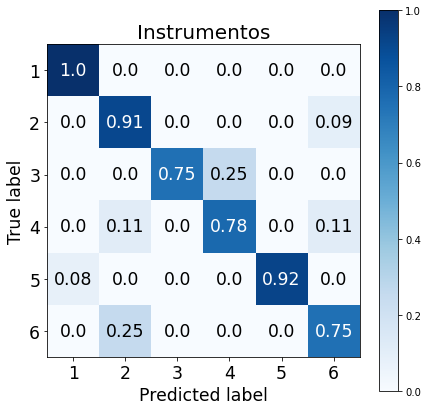

In [167]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_logictic, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

In [168]:
#print('Área bajo la curva ROC:',"% 1.3f" % roc_auc_score(y_test, y_hat, multi_class='ovr'))